In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import sklearn
import seaborn as sb
import random
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score
import warnings
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data.csv', delimiter = ',')
df = df.reindex(np.random.permutation(df.index))
#df.info()
df.describe()
#df

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


<Axes: >

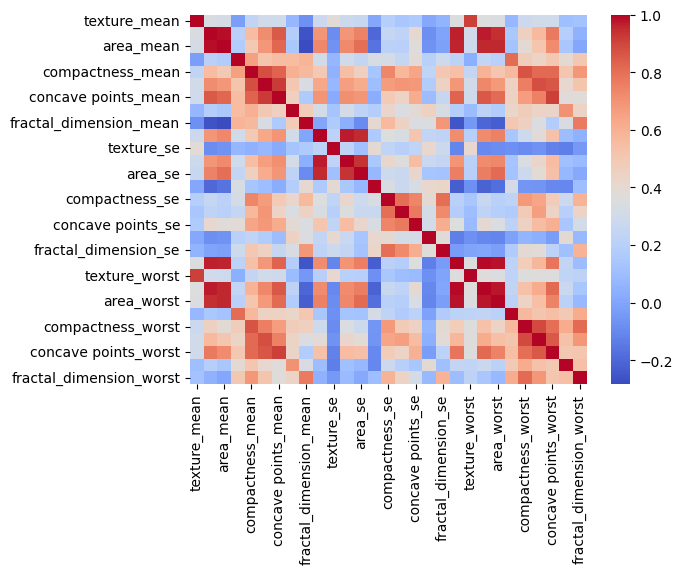

In [3]:
df = df.drop(columns='id')
df = df.drop(columns='Unnamed: 32')
#print(df.diagnosis)
classAnswerData = df['diagnosis'].map({'M':1,'B':0})

features = df.iloc[:, 2:]

# Compute the correlation matrix
corr_matrix = features.corr()

# Visualize the correlation matrix using a heatmap
sb.heatmap(corr_matrix, cmap='coolwarm')

In [4]:
def compute_adaptive_similarity_graph(X, quantile=0.5, cap_similarity=1.0):
    # Compute pairwise squared Euclidean distances
    pairwise_distances = cdist(X, X, metric='sqeuclidean')

    # Determine an adaptive gamma based on the chosen quantile of pairwise distances
    gamma = 1 / (2 * np.quantile(pairwise_distances, quantile))

    # Compute similarity matrix using the Gaussian kernel with adaptive gamma
    similarity_matrix = np.exp(-gamma * pairwise_distances)

    # Cap similarity values to handle high similarity between extremely close points
    similarity_matrix = np.clip(similarity_matrix, 0, cap_similarity)

    return similarity_matrix

In [5]:
import numpy as np

def compute_laplacian_matrix(similarity_matrix):
    # Compute the degree matrix as a diagonal matrix of row sums of the similarity graph
    degree_matrix = np.diag(similarity_matrix.sum(axis=1))

    # Calculate the Laplacian matrix by subtracting the similarity graph from the degree matrix
    laplacian_matrix = degree_matrix - similarity_matrix

    return laplacian_matrix

In [6]:
def compute_eigenvectors(laplacian_matrix, k):

    # Compute the k smallest eigenvalues and corresponding eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    selected_eigenvectors = eigenvectors[:, :k]

    # Normalize the rows of the eigenvector matrix for k-means clustering
    row_norms = np.linalg.norm(selected_eigenvectors, axis=1, keepdims=True)

    # Avoid division by zero by setting zero norms to one before division
    row_norms[row_norms == 0] = 1
    normalized_eigenvectors = selected_eigenvectors / row_norms

    return normalized_eigenvectors

In [7]:
from sklearn.cluster import KMeans
import numpy as np

def run_kmeans(X, k=2, max_iter=10, predefined_indices=None, random_seed=None):

    # Check if predefined indices are provided for initializing centroids
    if k == 2 and predefined_indices:
        # Select one set of indices from predefined_indices for initial centroids
        initial_centroids = X[predefined_indices[0]]  # Choose the first set in predefined_indices
    else:
        # Use default k-means++ initialization if no predefined indices are given
        initial_centroids = 'k-means++'

    # Set up the KMeans model
    kmeans = KMeans(
        n_clusters=k,
        init=initial_centroids if isinstance(initial_centroids, np.ndarray) else initial_centroids,
        max_iter=max_iter,
        random_state=random_seed,
        n_init=1 if isinstance(initial_centroids, np.ndarray) else 10
    )

    # Fit the model to the data
    kmeans.fit(X)

    # Get centroids and labels
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return centroids, labels


# Define data and predefined indices for k=2
list_of_indices_for_k_equal_2 = [[546, 49], [246, 74], [178, 477], [190, 294], [345, 36]]
X = np.random.rand(569, 2)

centroids, labels = run_kmeans(X, k=2, max_iter=10, predefined_indices=list_of_indices_for_k_equal_2, random_seed=42)
print("Centroids:\n", centroids)
print("Labels:\n", labels)

Centroids:
 [[0.24087101 0.50966246]
 [0.73793462 0.46077321]]
Labels:
 [0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0
 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1
 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1
 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0
 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1
 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0
 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0
 1 1 1 0 1 0 0 1 1 1 0 1 1 1

In [9]:

def spectralClustering(X, k = 2):
    simGraph = compute_adaptive_similarity_graph(X)
    lapMat = compute_laplacian_matrix(simGraph)
    normalizedEigenVectors = compute_eigenvectors(lapMat, 2)
    return run_kmeans(normalizedEigenVectors, 2)



X = df[['texture_mean', 'radius_mean', 'perimeter_mean','area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
        'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']].values
centroids, labels = spectralClustering(X, 2)

Text(0.5, 1.0, 'Actual Clusters')

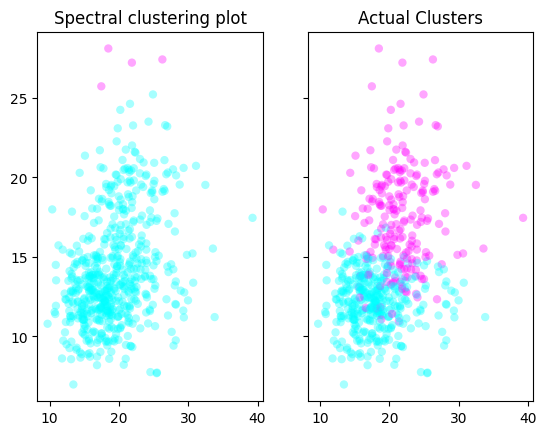

In [10]:
f, (spec, actual) = plt.subplots(1,2, sharey=True)

spec.scatter(X[:,0],X[:,1],  c=labels, cmap = "cool", edgecolor = "None", alpha=0.35)
spec.set_title('Spectral clustering plot')

actual.scatter(X[:,0], X[:,1],  c=classAnswerData, cmap = "cool", edgecolor = "None", alpha=0.35)
actual.set_title('Actual Clusters')



In [11]:

warnings.filterwarnings("ignore", category=FutureWarning, message = "'Series.swapaxes' is deprecated")
number_splits = 10
performance = []
splits = np.array_split(X, number_splits)
y_splits = np.array_split(classAnswerData, number_splits)

for i in range(number_splits):
  performance.append(spectralClustering(splits[i], 2))


In [12]:
def calculate_silhouette_score(i):
  return silhouette_score(performance[i][1].reshape(-1, 1), y_splits[i].values.ravel())

silhouette_scores = []
for i in range(1,10):
  score = calculate_silhouette_score(i)
  silhouette_scores.append(score)
print(silhouette_scores)


[0.14035087719298245, 0.45614035087719296, 0.6105263157894738, 0.1945080091533181, 0.46271929824561403, 0.0, 0.6006191950464396, 0.38596491228070173, 0.23214285714285715]


In [13]:

nmi_score = []

def calculate_normalized_score(i):
    return normalized_mutual_info_score(labels_pred=performance[i][1], labels_true=y_splits[i].values)

for i in range(1, 10):
    score = calculate_normalized_score(i)
    nmi_score.append(score)

print(nmi_score)

[0.037885860120948384, 0.06655785313685797, 0.37286541633128845, 0.07502032196249876, 0.16481830327203417, 0.030734352322170883, 0.4100211756997951, 0.05776683211777362, 0.0445922165401307]


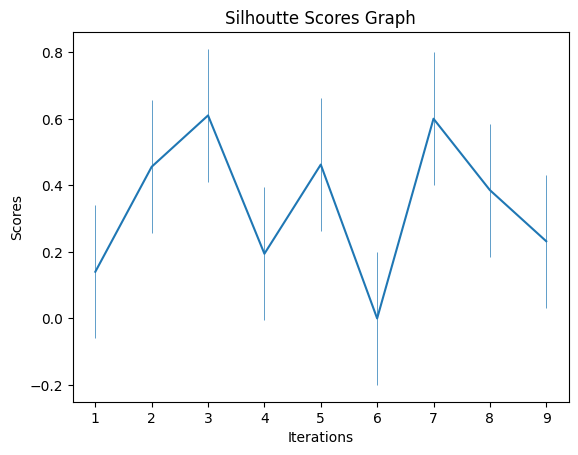

In [14]:
x_values = list(range(1, 10))
y_values = silhouette_scores
y_error = np.std(silhouette_scores)

plt.errorbar(x = x_values, y = y_values, yerr = y_error, elinewidth = 0.5)
plt.title('Silhoutte Scores Graph')
plt.ylabel('Scores')
plt.xlabel('Iterations')
plt.show()

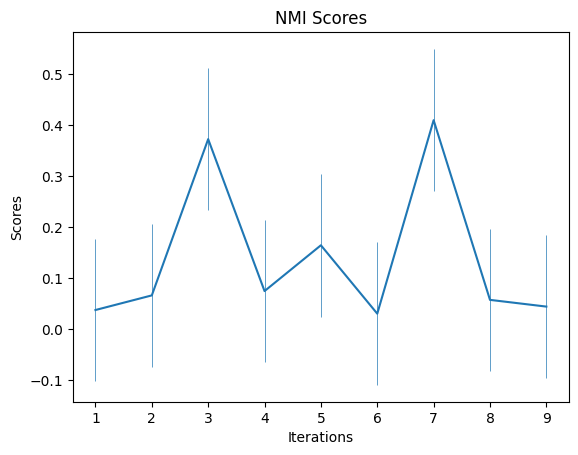

In [15]:
x_values = list(range(1, 10))
y_values = nmi_score
y_error = np.std(nmi_score)
plt.errorbar(x = x_values, y = y_values, yerr = y_error, elinewidth = 0.5)
plt.title('NMI Scores')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.show()

In [16]:
np.mean(nmi_score)

def load_shuffle_data(file):
  df = pd.read_csv(file)
  df = df.sample(frac=1).reset_index(drop=True)
  return df

new_df = load_shuffle_data('final.csv')
new_X = new_df[['Feature 1', 'Feature 2']].values
new_df.describe()
new_df

,Feature 1,Feature 2,Class/Cluster
0,8.500,0.000000,1
1,4.180,0.000000,1
2,2.080,0.000000,1
3,3.000,1.629463,2
4,7.405,0.000000,1
5,6.320,0.000000,1
6,0.000,1.005000,1
7,0.000,4.367583,1
8,3.125,0.000000,1
9,0.000,2.042871,1


In [17]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto')
nbrs.fit(new_X)

distances, indices = nbrs.kneighbors(new_X)

# Create the adjacency matrix based on nearest neighbors
n_samples = new_X.shape[0]
AdjacencyMatrix = np.zeros((n_samples, n_samples), dtype=int)

for i in range(n_samples):
    for j in indices[i, 1:]:
        AdjacencyMatrix[i, j] = 1
        AdjacencyMatrix[j, i] = 1


print(AdjacencyMatrix)

[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [18]:
DegreeMatrix = np.diag(np.sum(AdjacencyMatrix, axis=1))
#print(DegreeMatrix)

LaplacianMatrix = DegreeMatrix - AdjacencyMatrix
#print(Laplacian)

d = np.linalg.inv(np.sqrt(DegreeMatrix))
#print(DMSQRTINV)

NormalizedLaplacian = d@LaplacianMatrix@d
#print(NormalizedLaplacian)


In [19]:
_, eigenVectorsOfNormalizedLaplacian = np.linalg.eigh(NormalizedLaplacian)
spectralEmbeddings = eigenVectorsOfNormalizedLaplacian[:, :2] / np.linalg.norm(eigenVectorsOfNormalizedLaplacian[:, :2], axis = 0)
print("Spectral Embeddings:\n", spectralEmbeddings)

Spectral Embeddings:
 [[ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.01561567  0.49975609]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.19602047 -0.00612497]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.02208389  0.70676184]
 [ 0.01561567  0.49975609]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.2772148  -0.00866201]
 [ 0.19602047 -0.00612497]]


Iteration 1 Objective Function 0.9651614261891971
Iteration 2 Objective Function 0.039907976478450576
Iteration 3 Objective Function 0.039907976478450576
Iteration 4 Objective Function 0.039907976478450576
Iteration 5 Objective Function 0.039907976478450576
Iteration 6 Objective Function 0.039907976478450576
Iteration 7 Objective Function 0.039907976478450576
Iteration 8 Objective Function 0.039907976478450576
Iteration 9 Objective Function 0.039907976478450576
Iteration 10 Objective Function 0.039907976478450576


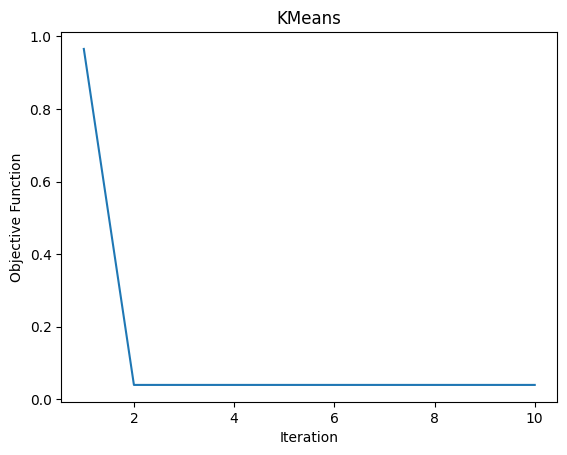

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def init_centroids(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False), :]

def clusters(X, centroids):
    assignments = np.zeros(X.shape[0])
    for j in range(X.shape[0]):
        dist = np.sum((X[j, :] - centroids) ** 2, axis=1)
        assignments[j] = np.argmin(dist)
    return assignments

def update_centroids(X, assignments, k):
    centroids = np.zeros((k, X.shape[1]))
    for j in range(k):
        mask = (assignments == j)
        if np.sum(mask) > 0:
            centroids[j, :] = np.mean(X[mask, :], axis=0)
    return centroids

def cal_objective(X, assignments, centroids):
    y = np.sum((X - centroids[assignments.astype(int), :]) ** 2)
    return y

def k_means(X, k, max_iterations=10):
    centroids = init_centroids(X, k)
    obj_function = np.zeros(max_iterations)

    for i in range(max_iterations):
        assignments = clusters(X, centroids)
        centroids = update_centroids(X, assignments, k)
        obj_function[i] = cal_objective(X, assignments, centroids)
        print("Iteration", i+1, "Objective Function", obj_function[i])

    return assignments, centroids, obj_function

# Run k-means algorithm with k=2
assignments, centroids, obj_function = k_means(spectralEmbeddings, 2)

plt.plot(np.arange(1, len(obj_function) + 1), obj_function)
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.title('KMeans')
plt.show()


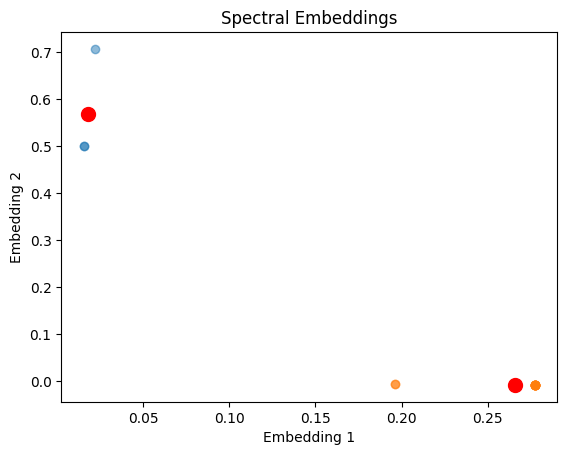

In [29]:
for cluster_id in np.unique(assignments):
  cluster_pts = spectralEmbeddings[assignments == cluster_id]
  plt.scatter(cluster_pts[:, 0], cluster_pts[:, 1], alpha=0.5, label = f'Cluster {int(cluster_id)}')


plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=100, color='red', label='Centroids')

plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.title('Spectral Embeddings')
plt.show()

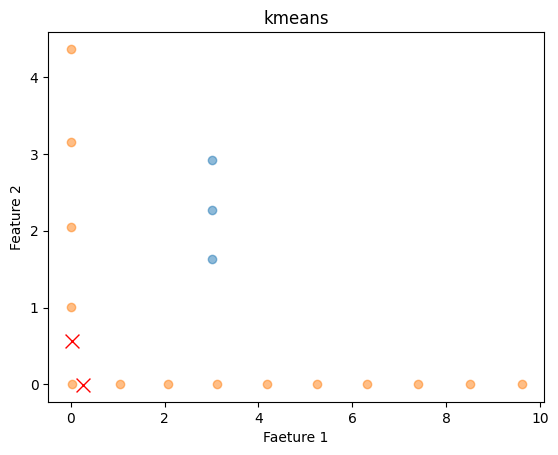

In [31]:
unique_assignments = np.unique(assignments)
for cluster_id in unique_assignments:
  cluster_pts = new_X[assignments == cluster_id]
  plt.scatter(cluster_pts[:, 0], cluster_pts[:, 1], alpha=0.5, label=f'Cluster {int(cluster_id)}')

plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidth=1, color='red', label='centroids')

plt.xlabel('Faeture 1')
plt.ylabel('Feature 2')
plt.title('kmeans')
plt.show()